In [1]:
import os
import sys
import itertools

import pandas as pd
import numpy as np
import pickle
import unsupervised_learning_util as utl
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import clustering_utl as cl_utl

from sklearn.decomposition import PCA, FastICA, KernelPCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS, Isomap, SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn.metrics import homogeneity_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from warnings import simplefilter
from scipy import linalg

limit = 2000

plt.tight_layout()
plt.style.use("ggplot")
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['savefig.dpi'] = 500


NJOBS = 32
VERBOSE = 0

%matplotlib inline

C:\ProgramData\Anaconda3\envs\CS7641\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
gathered_data = utl.setup(["MNIST"])
gathered_data_fashion = utl.setup(["Fashion-MNIST"])

mnist = {}
fashion_mnist = {}
# mnist_not_scaled = {}
# fashion_mnist_not_scaled = {}

mnist['train_X'], mnist['train_y'], \
mnist['valid_X'], mnist['valid_y'], \
mnist['test_X'], mnist['test_y'] = utl.split_data(gathered_data["MNIST"]["X"],
                                                  gathered_data["MNIST"]["y"], minMax=True)
# mnist_not_scaled['train_X'], mnist_not_scaled['train_y'], \
# mnist_not_scaled['valid_X'], mnist_not_scaled['valid_y'], \
# mnist_not_scaled['test_X'], mnist_not_scaled['test_y'] = utl.split_data(
#     gathered_data["MNIST"]["X"], gathered_data["MNIST"]["y"], scale=False)

fashion_mnist['train_X'], fashion_mnist['train_y'], \
fashion_mnist['valid_X'], fashion_mnist['valid_y'], \
fashion_mnist['test_X'], fashion_mnist['test_y'] = utl.split_data(gathered_data_fashion["Fashion-MNIST"]["X"],
                                                                  gathered_data_fashion["Fashion-MNIST"]["y"],
                                                                  minMax=True)

# fashion_mnist_not_scaled['train_X'], fashion_mnist_not_scaled['train_y'], \
# fashion_mnist_not_scaled['valid_X'], fashion_mnist_not_scaled['valid_y'], \
# fashion_mnist_not_scaled['test_X'], fashion_mnist_not_scaled['test_y'] = utl.split_data(
#     gathered_data_fashion["Fashion-MNIST"]["X"], gathered_data_fashion["Fashion-MNIST"]["y"], scale=False)

dataset folder already exists.
MNIST dataset found:
	Loading MNIST.feather
	Finished loading MNIST dataset
dataset folder already exists.
Fashion-MNIST dataset found:
	Loading Fashion-MNIST.feather
	Finished loading Fashion-MNIST dataset


# Determine Scaling

In [ ]:
temp_folder = "Clustering/" + "KMeans/"
utl.check_folder(temp_folder)
save_dir = os.getcwd() + temp_folder
limit = 2000
idx = [i for i in range(2, 15, 2)]
cols = [limit]


inertia_results_scaled = pd.DataFrame(columns=["Scaled"],
                               index=idx,
                               data=np.zeros(shape=(len(idx), len(cols))))
inertia_results_not_scaled = pd.DataFrame(columns=["Not Scaled"],
                               index=idx,
                               data=np.zeros(shape=(len(idx), len(cols))))

silhouette_average_results_scaled = pd.DataFrame(columns=["Scaled"], index=idx,
                                          data=np.zeros(shape=(len(idx), len(cols))))
silhouette_average_results_not_scaled = pd.DataFrame(columns=["Not Scaled"], index=idx,
                                          data=np.zeros(shape=(len(idx), len(cols))))
silhouette_sample_results_scaled = {}
silhouette_sample_results_not_scaled = {}
best_inertia = -1e12
best_inertia_num_cluster = 0
best_silhouette = 0
best_silhouette_num_cluster = 0
print("Starting K-Means Clustering")

for _df in ["Scaled", "Not Scaled"]:
    for k in idx:
        print(f"\t\t{_df} Number of Clusters: {k}")
        if _df == "Scaled":
            temp_train_X = mnist_scaled["train_X"].iloc[:limit, :]
            k_means = KMeans(n_clusters=k, verbose=VERBOSE, random_state=42).fit(temp_train_X)
            inertia = k_means.inertia_
            inertia_results_scaled.loc[k, "Scaled"] = inertia
            silhouette_average = silhouette_score(temp_train_X, k_means.labels_)
            silhouette_average_results_scaled.loc[k, "Scaled"] = silhouette_average
            temp_silhouette_sample_results = silhouette_samples(temp_train_X, k_means.labels_)
            silhouette_sample_results_scaled[f"NumClusters_{k} DataSize_{limit}"] = temp_silhouette_sample_results
            print(f"\t{_df} Current Intertia: {inertia}, Silhouette: {silhouette_average}")
            if inertia > best_inertia:
                best_inertia = inertia
                best_inertia_num_cluster = k
                print(f"\t{_df} New Best Inertia: {best_inertia}")
                print(f"\t\t{_df} Inertia Best Number of Clusters: {best_inertia_num_cluster}")
            if silhouette_average > best_silhouette:
                best_silhouette = silhouette_average
                best_silhouette_num_cluster = k
                print(f"\t{_df} New Best Silhouette: {best_silhouette}")
                print(f"\t\t{_df} Silhouette Best Number of Clusters: {best_silhouette_num_cluster}")
        elif _df == "Not Scaled":
            temp_train_X = mnist_not_scaled["train_X"].iloc[:limit, :]
            k_means = KMeans(n_clusters=k, verbose=VERBOSE, random_state=42).fit(temp_train_X)
            inertia = k_means.inertia_
            inertia_results_not_scaled.loc[k, "Not Scaled"] = inertia
            silhouette_average = silhouette_score(temp_train_X, k_means.labels_)
            silhouette_average_results_not_scaled.loc[k, "Not Scaled"] = silhouette_average
            temp_silhouette_sample_results = silhouette_samples(temp_train_X, k_means.labels_)
            silhouette_sample_results_not_scaled[f"NumClusters_{k} DataSize_{limit}"] = temp_silhouette_sample_results
            print(f"\t{_df} Current Intertia: {inertia}, Silhouette: {silhouette_average}")
            if inertia > best_inertia:
                best_inertia = inertia
                best_inertia_num_cluster = k
                print(f"\t{_df} New Best Inertia: {best_inertia}")
                print(f"\t\t{_df} Inertia Best Number of Clusters: {best_inertia_num_cluster}")
            if silhouette_average > best_silhouette:
                best_silhouette = silhouette_average
                best_silhouette_num_cluster = k
                print(f"\t{_df} New Best Silhouette: {best_silhouette}")
                print(f"\t\t{_df} Silhouette Best Number of Clusters: {best_silhouette_num_cluster}")


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

inertia_results_scaled.plot(ax=ax1, label="Scaled")
inertia_results_not_scaled.plot(ax=ax1, label="Not Scaled")
ax1.set_title(f"K Means Clustering\nInertia", fontsize=15, weight='bold')
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='white')
ax1.set_xlabel("K Clusters", fontsize=15, weight='heavy')
ax1.set_ylabel("Inertia", fontsize=15, weight='heavy')
ax1.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
plt.tight_layout()

silhouette_average_results_scaled.plot(ax=ax2, label="Scale")
silhouette_average_results_not_scaled.plot(ax=ax2, label="Not Scaled")
ax2.set_title(f"K Means Clusters\nSilhouette", fontsize=15, weight='bold')
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='white')
ax2.set_xlabel("K Clusters", fontsize=15, weight='heavy')
ax2.set_ylabel("Average Silhouette Score", fontsize=15, weight='heavy')
ax2.legend(loc="best", markerscale=1.1, frameon=True,
                   edgecolor="black", fancybox=True, shadow=True)
plt.tight_layout()

plt.savefig(f"{os.getcwd()}/{temp_folder}KMEans_Combined_Scaled_Vs_NotScaled.png", bbox_inches='tight')
plt.close("all")

# K-Means Clustering

In [ ]:
gathered_data = utl.setup(["MNIST"])
gathered_data_fashion = utl.setup(["Fashion-MNIST"])
limit = 10000
mnist = {}
fashion_mnist = {}
mnist['train_X'], mnist['train_y'], \
mnist['valid_X'], mnist['valid_y'], \
mnist['test_X'], mnist['test_y'] = utl.split_data(gathered_data["MNIST"]["X"],
                                                  gathered_data["MNIST"]["y"], minMax=True)

fashion_mnist['train_X'], fashion_mnist['train_y'], \
fashion_mnist['valid_X'], fashion_mnist['valid_y'], \
fashion_mnist['test_X'], fashion_mnist['test_y'] = utl.split_data(gathered_data_fashion["Fashion-MNIST"]["X"],
                                                                  gathered_data_fashion["Fashion-MNIST"]["y"],
                                                                  minMax=True)

In [ ]:
mnist_results = cl_utl.run_kmeans(data_X=mnist["train_X"].loc[:limit, :], data_y=mnist["train_y"].loc[:limit],
                            max_clusters=40, dataset_name="MNIST", verbose=1)
fashion_results = cl_utl.run_kmeans(data_X=fashion_mnist["train_X"].loc[:limit, :], data_y=fashion_mnist["train_y"].loc[:limit],
                            max_clusters=40, dataset_name="Fashion_MNIST", verbose=1)

In [ ]:
utl.check_folder("Part1")
with open(f"{os.getcwd()}/Part1/KMeans_Clustering_MNIST_Results.pkl", "wb") as output_file:
    pickle.dump(mnist_results, output_file)
    output_file.close()

In [ ]:
with open(f"{os.getcwd()}/Part1/KMeans_Clustering_Fashion_MNIST_Results.pkl", "wb") as output_file:
    pickle.dump(fashion_results, output_file)
    output_file.close()

# Expectation Maximization 

In [ ]:
em_mnist_results = cl_utl.run_em(data_X=mnist["train_X"].iloc[:limit, :], data_y=mnist["train_y"].iloc[:limit],
                                 max_components=30, dataset_name="MNIST", standalone=True)

In [ ]:
em_fashion_results = cl_utl.run_em(data_X=fashion_mnist["train_X"].iloc[:limit, :], data_y=fashion_mnist["train_y"].iloc[:limit],
                                 max_components=30, dataset_name="Fashion-MNIST", standalone=True)

In [3]:
with open(f"{os.getcwd()}/Clustering/EM_Results_MNIST.pkl", "rb") as input_file:
    em_mnist_results = pickle.load(input_file)
    input_file.close()
with open(f"{os.getcwd()}/Clustering/EM_Results_Fashion-MNIST.pkl", "rb") as input_file:
    em_fashion_results = pickle.load(input_file)
    input_file.close()

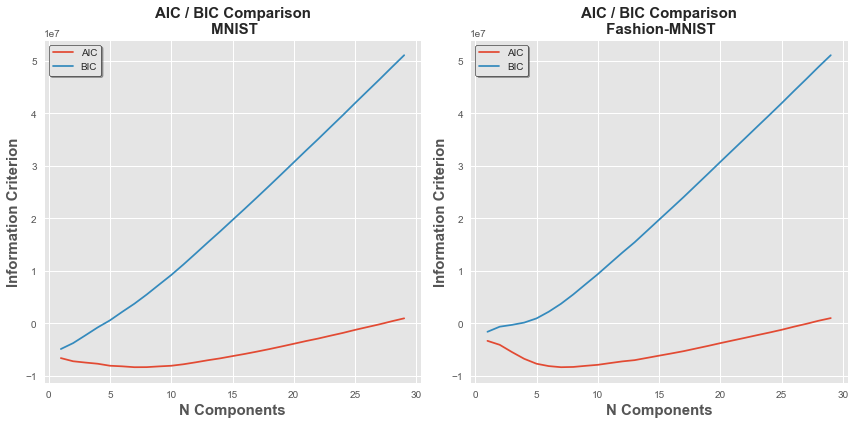

In [4]:
cl_utl.plot_em(em_mnist_results, em_fashion_results)

In [ ]:
cl_utl.plot_combined_kmeans(mnist_X=mnist["train_X"].loc[:limit, :], 
                            fashion_X=fashion_mnist["train_X"].loc[:limit, :], max_clusters=40)